<a href="https://colab.research.google.com/github/wojciech-malinowski/course-v3/blob/master/deblurrificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg19_bn,vgg16_bn
from google.colab import drive

import numpy as np
import time
import cv2
import numpy
import PIL.Image
from PIL import ImageFilter
import re
import os
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def resize(path,path_to_save = None,size_x = 224, size_y = 224):
  
  if not path_to_save:
    path_to_save = Path(str(path.parents[0]))
    path_to_save = path_to_save/(f'images_{size_x}')
    print(path_to_save)
  
  #checking if folder where the resized photos are going to be saved exists
  if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
  
  if not os.path.exists(path_to_save/'unblurred'):
    os.makedirs(path_to_save/'unblurred')

  #list of all images that are going to be resized
  image_list = path.ls()
  
  for image in image_list:
    img = PIL.Image.open(image)
    img = img.resize((size_x,size_x), PIL.Image.ANTIALIAS)
    img_name = re.search(r'\d+\.jpg',str(image)).group(0)
    
    print(path_to_save/'unblurred'/img_name)
    img.save(path_to_save/'unblurred'/img_name)

  return path_to_save

In [0]:
def blur(path,path_to_save = None, want_to_see = False, radius = 3):
  if not path_to_save:
    path_to_save = path/f'blurred_{radius}'
  
  #make a folder where blurred images will be saved
  if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

  image_list = (path/'unblurred').ls()
  for image in image_list:
    img_name = re.search(r'\d+\.jpg',str(image)).group(0)

    img = PIL.Image.open(image)
    img = img.filter(ImageFilter.GaussianBlur(radius=radius))

    img.save(path_to_save/img_name)



In [0]:
def resize_and_blur(path,size = 224 ,radius = 3,create_range = True):
  resized_images_path = resize(path,size_x = size,size_y = size)
  if create_range == False:
    blur(resized_images_path,radius = radius)
  else:
    for radius_ in np.arange(0.5, 5.5, 0.5):
      blur(resized_images_path,radius = radius_)

In [0]:
path = Path('/content/drive/My Drive/AI projects/unblurred')

In [0]:
resize_and_blur(path)


NameError: ignored

In [0]:
#having done the data let's move to the NN

In [0]:
bs = 8
size = 224

In [0]:
arch = models.resnet34

In [0]:
x_paths = [Path('/content/drive/My Drive/AI projects/images_224/blurred_'+str(x)) for x in np.arange(0.5,5.5,0.5)]
y_path = Path('/content/drive/My Drive/AI projects/images_224/unblurred')

In [13]:
x_paths

[PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_0.5'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_1.0'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_1.5'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_2.0'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_2.5'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_3.0'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_3.5'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_4.0'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_4.5'),
 PosixPath('/content/drive/My Drive/AI projects/images_224/blurred_5.0')]

In [0]:
#function that maps from the data to target
get_y_fn = lambda x: y_path/x.name

In [0]:
def get_data(x_paths = x_paths,y_path = y_path,n = 0,get_y_fn = get_y_fn):
  src = ImageImageList.from_folder(x_paths[n]).split_by_rand_pct(0.2).label_from_func(get_y_fn)
  data = (src.transform(get_transforms(), size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
        )

  return data



In [0]:
data = get_data(n = 3)

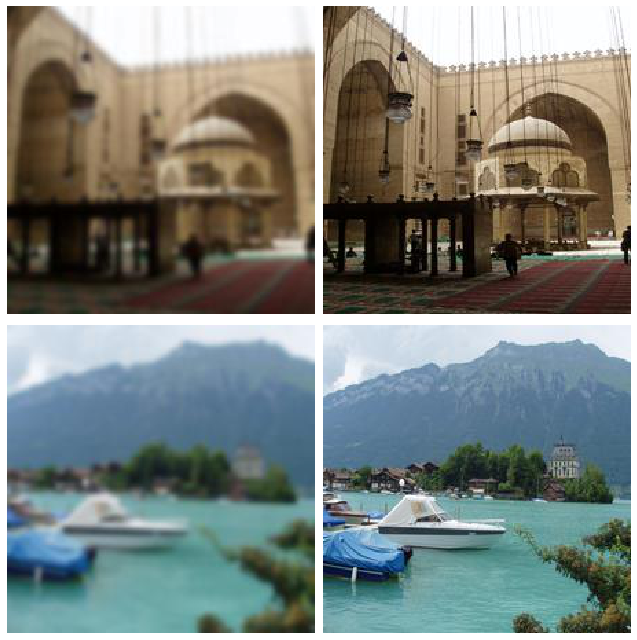

In [34]:
#show batch 
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))


In [0]:
## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)


In [19]:
gram_matrix(t)

tensor([[[0.1223, 0.1080, 0.0876],
         [0.1080, 0.0964, 0.0792],
         [0.0876, 0.0792, 0.0664]],

        [[0.1223, 0.1080, 0.0876],
         [0.1080, 0.0964, 0.0792],
         [0.0876, 0.0792, 0.0664]]])

In [0]:
base_loss = F.l1_loss

In [21]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 165MB/s]


In [22]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [0]:
#Training

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


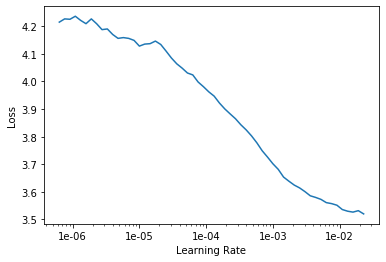

In [27]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-04

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.740418,2.466951,0.163716,0.270353,0.309464,0.079037,0.714207,0.868277,0.061896,03:49
1,2.270053,2.020316,0.110617,0.240286,0.281759,0.067089,0.558214,0.708558,0.053793,01:46
2,1.913758,1.747587,0.090527,0.217882,0.252750,0.060765,0.469198,0.606411,0.050053,01:46
3,1.627431,1.412152,0.075399,0.186558,0.219568,0.056146,0.340559,0.486420,0.047500,01:46
4,1.289254,1.177823,0.062371,0.166802,0.194002,0.053252,0.277175,0.378120,0.046101,01:45
5,1.096050,1.106403,0.047676,0.160512,0.186294,0.052269,0.257525,0.356595,0.045532,01:45
6,1.034946,1.066696,0.046217,0.156389,0.179588,0.050597,0.242551,0.346868,0.044485,01:45
7,0.991548,1.026065,0.043747,0.151499,0.175551,0.049680,0.234851,0.327015,0.043720,01:45
8,0.963888,1.017746,0.039753,0.149249,0.173078,0.049730,0.242159,0.319851,0.043926,01:45
9,0.899748,0.931368,0.036455,0.148128,0.169202,0.048805,0.202084,0.283459,0.043235,01:45


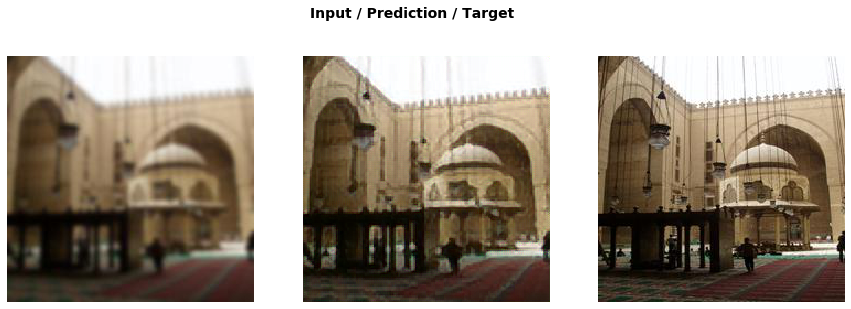

In [36]:
do_fit('224-vgg-19-resnet_34-unfreezed', slice(lr*10))


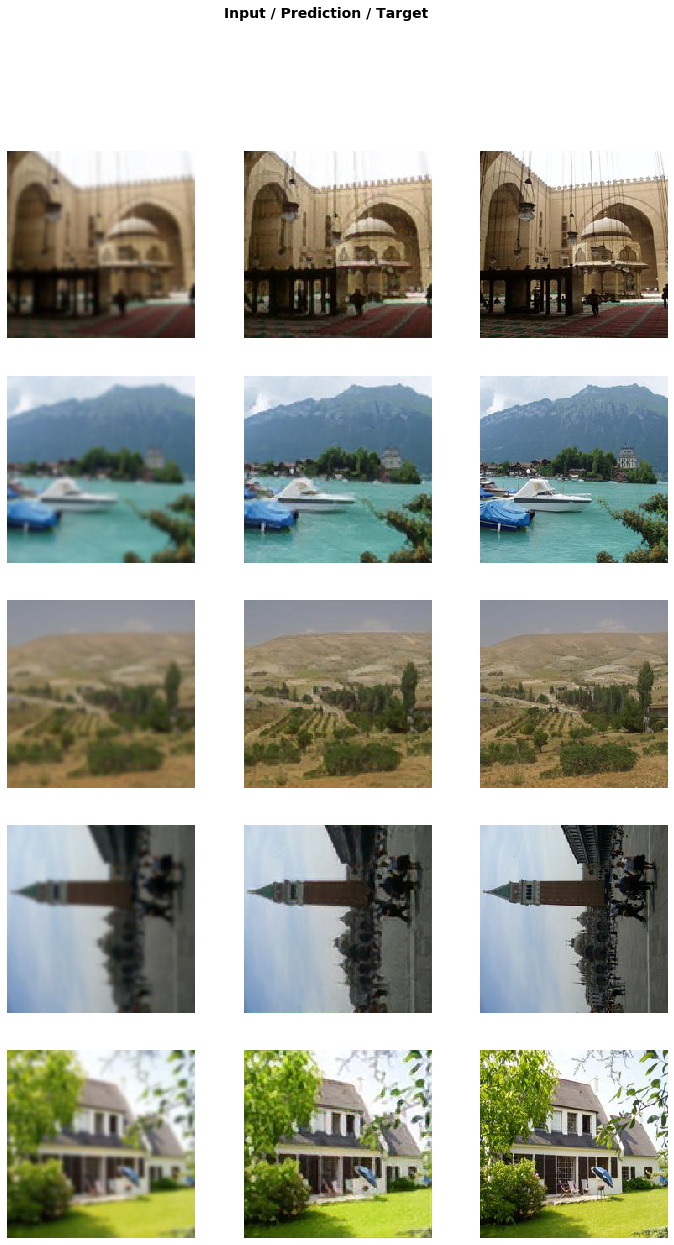

In [37]:
learn.show_results()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.854982,0.926456,0.036104,0.147220,0.168290,0.048335,0.202663,0.280947,0.042896,01:50
1,0.853460,0.924201,0.036036,0.147344,0.168048,0.048513,0.200963,0.280306,0.042991,01:49
2,0.852563,0.920073,0.035923,0.146770,0.167350,0.048230,0.200965,0.278065,0.042769,01:48
3,0.844413,0.918100,0.035686,0.146493,0.167042,0.048090,0.200758,0.277339,0.042691,01:49
4,0.846222,0.921513,0.035565,0.146123,0.166832,0.048199,0.202037,0.280006,0.042750,01:49
5,0.838209,0.909106,0.035824,0.146132,0.166130,0.047977,0.196133,0.274375,0.042535,01:49
6,0.839303,0.917604,0.035510,0.145393,0.166409,0.047712,0.199552,0.280645,0.042382,01:49
7,0.833576,0.931170,0.036568,0.145375,0.166733,0.047967,0.206819,0.285112,0.042595,01:48
8,0.829719,0.899398,0.035895,0.145225,0.165477,0.047673,0.192362,0.270456,0.042311,01:49
9,0.822468,0.894978,0.035175,0.145133,0.164822,0.047704,0.190498,0.269367,0.042279,01:49


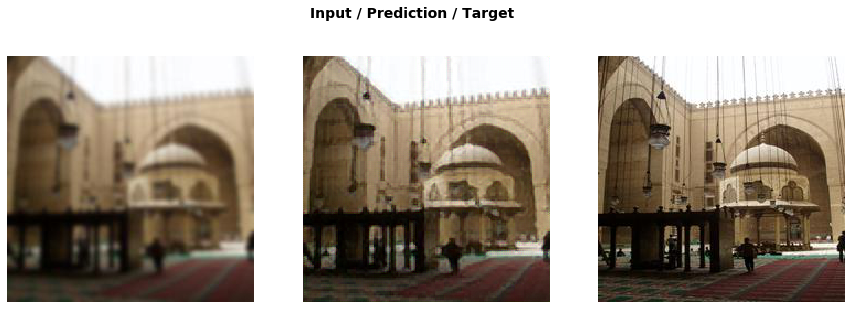

In [38]:
learn.unfreeze()
do_fit('224-vgg-19-resnet_34-ununfreezed', slice(1e-6,lr))


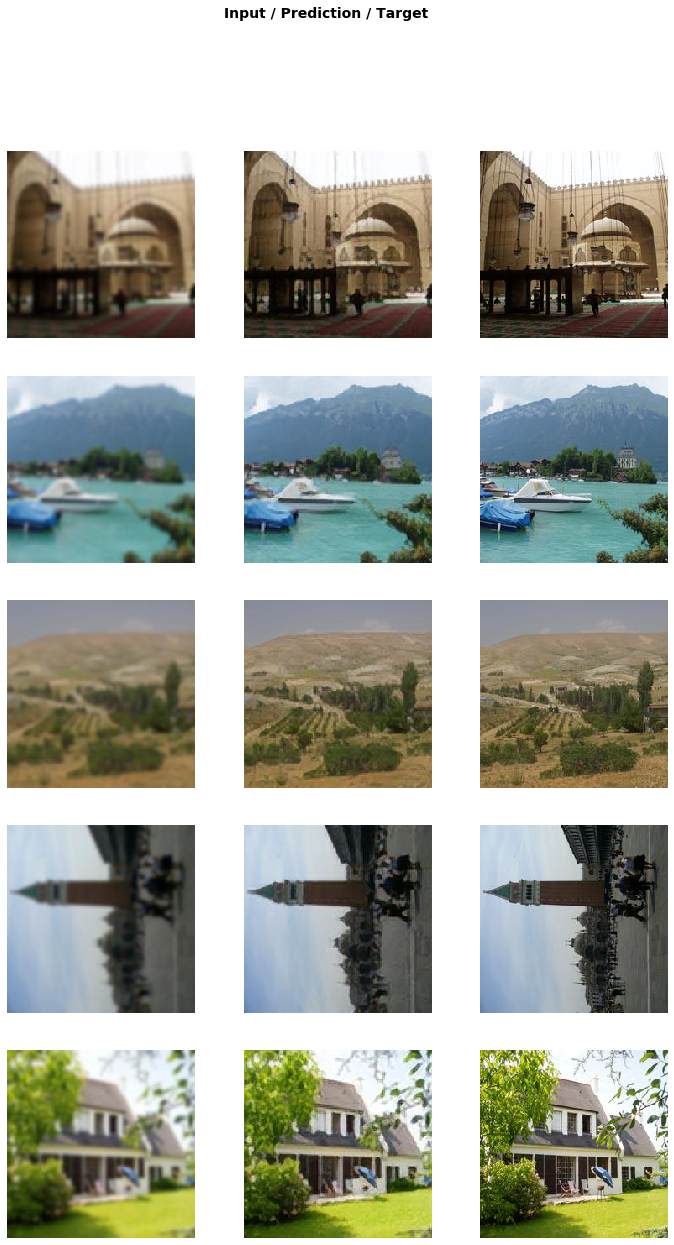

In [39]:
learn.show_results()